<a href="https://colab.research.google.com/github/ykitaguchi77/Colab_Scripts/blob/master/Efficient%E3%81%AE%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF%E7%BD%AE%E3%81%8D%E6%8F%9B%E3%81%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**GravCont: EfficientNet_b4_ImageNet**

In [2]:
from __future__ import print_function, division
!pip install torch_optimizer

import torch
import torch.nn as nn
import torch_optimizer as optim
import torch.utils.data as data
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math
import shutil

#Advanced Pytorchから
import glob
import os.path as osp
import random
import json
from PIL import Image
from tqdm import tqdm
%matplotlib inline

#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set random seem for reproducibility
manualSeed = 1234
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.cuda.manual_seed(manualSeed)

torch.torch.backends.cudnn.benchmark = True
torch.torch.backends.cudnn.enabled = True


'''
grav: 甲状腺眼症
cont: コントロール
黒の空白を挿入することにより225px*225pxの画像を生成、EfficientNetを用いて転移学習
－－－－－－－－－－－－－－
データの構造
gravcont.zip ------grav
               |---cont
'''                                     

#google driveをcolabolatoryにマウント
from google.colab import drive
drive.mount('/content/drive')

Random Seed:  1234
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**モジュール群**

['cont', 'grav']
cont_train:266
grav_train:266
cont_val:67
grav_val:67
training data set_total：532
validating data set_total：134


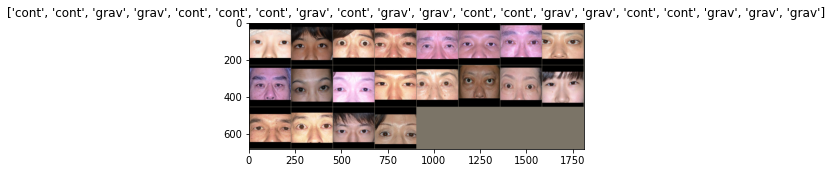

In [50]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる

"""
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。
    訓練時はRandomResizedCropとRandomHorizontalFlipでデータオーギュメンテーションする。


    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
"""

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.75,1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/My Drive/Deep_learning/gravcont_seed_20200815'
n_samples = len(data_dir)

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=20,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



print(class_names)
k=0
for i in class_names:
    print(class_names[k]+"_train:"+str(len(os.listdir(path=data_dir + '/train/'+class_names[k]))))
    k+=1
k=0
for i in class_names:
    print(class_names[k]+"_val:"+str(len(os.listdir(path=data_dir + '/val/'+class_names[k]))))
    k+=1

print("training data set_total："+ str(len(image_datasets['train'])))
print("validating data set_total："+str(len(image_datasets['val'])))


#少数の画像を可視化
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


#Defining early stopping class
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss


#Train models
def train_model(model, criterion, optimizer, patience, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # to track the training loss as the model trains
    train_loss = []
    # to track the validation loss as the model trains
    valid_loss = []


    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase] 
            
            # record train_loss and valid_loss
            if phase == 'train':
                train_loss.append(epoch_loss)
            if phase == 'val':
                valid_loss.append(epoch_loss)
            #print(train_loss)
            #print(valid_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
      
      # early_stopping needs the validation loss to check if it has decresed, 
      # and if it has, it will make a checkpoint of the current model
        if phase == 'val':    
            early_stopping(epoch_loss, model)
                
            if early_stopping.early_stop:
                print("Early stopping")
                break
        print()


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss, valid_loss


#Visualize model
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


#define EfficientNet (ここは不要）



#**Convnetの調整**

In [57]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet 

model_ft = EfficientNet.from_pretrained('efficientnet-b4')
num_ftrs = model_ft._fc.in_features
model_ft._fc = nn.Linear(num_ftrs, 2)

#GPU使用
model_ft = model_ft.to(device)

#損失関数を定義
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#https://blog.knjcode.com/adabound-memo/
#https://pypi.org/project/torch-optimizer/
optimizer_ft = optim.AdaBound(
    model_ft.parameters(),
    lr= 1e-3,
    betas= (0.9, 0.999),
    final_lr = 0.1,
    gamma=1e-3,
    eps= 1e-8,
    weight_decay=0,
    amsbound=False,
)

Loaded pretrained weights for efficientnet-b4


#**EfficientNetのネットワーク置き換え**

In [58]:
class Identity(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(1792, 2)

    def forward(self, x):
        x = self.fc(x)
        return x

model_ft.fc = Identity()

#**訓練と評価**

In [ ]:
model_ft, train_loss, valid_loss = train_model(model_ft, criterion, optimizer_ft,  patience=15, num_epochs=50)


Epoch 0/49
----------
train Loss: 0.5963 Acc: 0.7143
val Loss: 0.6923 Acc: 0.6791
Validation loss decreased (inf --> 0.692294).  Saving model ...

Epoch 1/49
----------
train Loss: 0.4134 Acc: 0.8515
val Loss: 0.5668 Acc: 0.8358
Validation loss decreased (0.692294 --> 0.566802).  Saving model ...

Epoch 2/49
----------
train Loss: 0.3882 Acc: 0.8534
val Loss: 0.4243 Acc: 0.8507
Validation loss decreased (0.566802 --> 0.424258).  Saving model ...

Epoch 3/49
----------
train Loss: 0.2964 Acc: 0.8722
val Loss: 0.5327 Acc: 0.8209
EarlyStopping counter: 1 out of 15

Epoch 4/49
----------
train Loss: 0.2349 Acc: 0.9060
val Loss: 0.4593 Acc: 0.8582
EarlyStopping counter: 2 out of 15

Epoch 5/49
----------
train Loss: 0.1485 Acc: 0.9380
val Loss: 0.7623 Acc: 0.8284
EarlyStopping counter: 3 out of 15

Epoch 6/49
----------
train Loss: 0.1837 Acc: 0.9380
val Loss: 0.4095 Acc: 0.8358
Validation loss decreased (0.424258 --> 0.409545).  Saving model ...

Epoch 7/49
----------
train Loss: 0.1064 Ac

#**Calculate Accuracy**
・True positive (TN)<br>
・False positive (FP)<br>
・True negative (TN)<br>
・False negative (FN)<br>

Accuracy = (TP + TN)/ (TP + TN + FP + FN)<br>
Precision = TP/(FP + TP) ※positive predictive value<br>
Recall = TP/(TP + FN)　※sensitivity<br>
Specificity = TN/(FP + TN)<br>
F_value = (2RecallPrecision)/(Recall+Precision)<br>

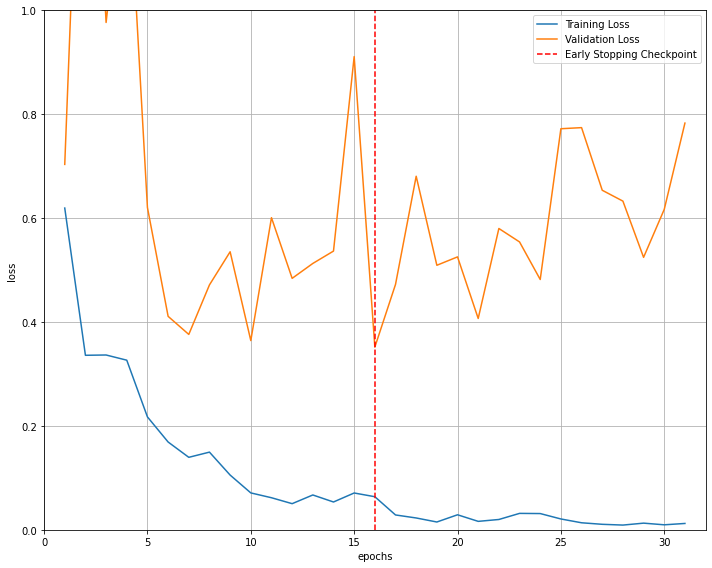

In [5]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 1.0) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

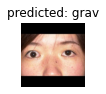

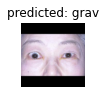

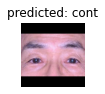

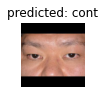

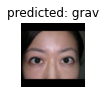

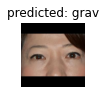

In [6]:
visualize_model(model_ft)

In [ ]:
#評価モードにする
model_ft.eval()

#valフォルダ内のファイル名を取得
image_path = glob.glob(data_dir + "/val/*/*")
random.shuffle(image_path)  #表示順をランダムにする
print('number of images: ' +str(len(image_path)))
#print(image_path) 



"""
#ファイル名よりラベルを抜き出し、'class_name'と定義
class_name = []
class_path = glob.glob('/content/drive/My Drive/Deep_learning/applstra/val/*')
for i in class_path:
    class_name.append(os.path.basename(i))  
print(class_name)
"""

#対象のパスからラベルを抜き出して表示
def getlabel(image_path):
      image_name = os.path.basename(image_path)
      label = os.path.basename(os.path.dirname(image_path))
      return(image_name, label)

'''
#変形後の画像を表示
def image_transform(image_path):

    image=Image.open(image_path)

    
    #変形した画像を表示する
    transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224)])
    image_transformed = transform(image)
    plt.imshow(np.array(image_transformed))
'''

#評価のための画像下処理
def image_transform(image_path):    
    image=Image.open(image_path)
    transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    image_tensor = transform(image)

    #バッチサイズの次元を先頭に追加した4Dテンソルに変換
    image_tensor.unsqueeze_(0)
    #print(image_tensor.size())  # torch.Size([1, 3, 224, 224])
    image_tensor = image_tensor.to(device) #model_ftをGPUに載せる

    return(image_tensor)

#モデルにした処理した画像を投入して予測結果を表示
def image_eval(image_tensor, label):
    output = model_ft(image_tensor)
    #print(output.size())  # torch.Size([1, 1000])
    #print(output)

    #model_pred:クラス名前、prob:確率、pred:クラス番号
    prob, pred = torch.topk(nn.Softmax(dim=1)(output), 1)
    model_pred = class_names[pred]
    
    #甲状腺眼症のprobabilityを計算（classが0なら1から減算、classが1ならそのまま）
    prob = abs(1-float(prob)-float(pred))
 
    return model_pred, prob, pred

    """
    #probalilityを計算する
    pred_prob = torch.topk(nn.Softmax(dim=1)(output), 1)[0]
    pred_class = torch.topk(nn.Softmax(dim=1)(output), 1)[1]
    if pred_class == 1:
        pred_prob = pred_prob
    elif pred_class == 0:
        pred_prob = 1- pred_prob
    return(model_pred, pred_prob)  #class_nameの番号で出力される
    """

def showImage(image_path):
    #画像のインポート
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    #画像のリサイズ
    height = img.shape[0]
    width = img.shape[1]
    resized_img = cv2.resize(img, (int(width*300/height), 300))
    cv2_imshow(resized_img)

def calculateAccuracy (TP, TN, FP, FN):
    accuracy = (TP + TN)/ (TP + TN + FP + FN)
    precision  = TP/(FP + TP)
    recall = TP/(TP + FN)
    specificity = TN/(FP + TN)
    f_value = (2*recall*precision)/(recall+precision)
    return(accuracy, precision, recall, specificity, f_value)


#ここからがメイン
TP, FP, TN, FN, TP, FP, TN, FN = [0,0,0,0,0,0,0,0]
image_name_list = []
label_list = []
model_pred_list = []
hum_pred_list = []

model_pred_class = []
model_pred_prob = []


for i in image_path:
      image_name, label = getlabel(i)  #画像の名前とラベルを取得
      image_tensor = image_transform(i)  #予測のための画像下処理
      model_pred, prob, pred = image_eval(image_tensor, label)  #予測結果を出力   
      #print('Image: '+ image_name)
      #print('Label: '+ label)
      #print('Pred: '+ model_pred)
      #showImage(i)  #画像を表示
      #print() #空白行を入れる
      time.sleep(0.1)

      image_name_list.append(image_name)
      label_list.append(label)
      model_pred_list.append(model_pred)

      model_pred_class.append(int(pred))
      model_pred_prob.append(float(prob))

      if label == class_names[0]:
          if model_pred == class_names[0]:
              TN += 1
          else:
              FP += 1
      elif label == class_names[1]:
          if model_pred == class_names[1]:
              TP += 1
          else:
              FN += 1
      

print(TP, FN, TN, FP)

#Accuracyを計算
accuracy, precision, recall, specificity, f_value = calculateAccuracy (TP, TN, FP, FN)
print('Accuracy: ' + str(accuracy))
print('Precision (positive predictive value): ' + str(precision))
print('Recall (sensitivity): ' + str(recall))
print('Specificity: ' + str(specificity))
print('F_value: ' + str(f_value))

print(model_pred_class)
print(model_pred_prob)

number of images: 134
59 8 61 6
Accuracy: 0.8955223880597015
Precision (positive predictive value): 0.9076923076923077
Recall (sensitivity): 0.8805970149253731
Specificity: 0.9104477611940298
F_value: 0.8939393939393939
[1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]
[0.9561910629272461, 0.9893732666969299, 0.9967695474624634, 0.011681437492370605, 0.9999785423278809, 0.9977245926856995, 2.384185791015625e-06, 0.9992450475692749, 0.10808610916137695, 0.3920801877975464, 0.9998989105224609, 0.02275913953781128, 3.0994415283203125e-06, 0.12613123655319214, 1.0, 2.5033950805664062e-06, 8.106231689453125e-06, 0.999977707862854, 0.99985444545

#**Drawing ROC curve**

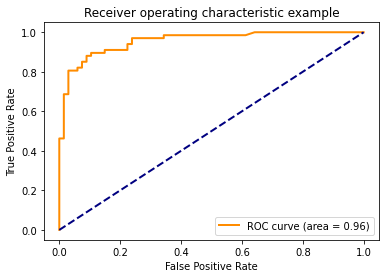

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_score = []
y_true = []

k=0
for i in label_list:
    if label_list[k] == 'cont':
          y_true.append(0)
    elif label_list[k] == 'grav':
          y_true.append(1)
    k+=1


#健康な状態を「0」、病気を「1」としてラベルよりリストを作成
y_true = y_true
#それぞれの画像における陽性の確率についてリストを作成
y_score = model_pred_prob

#print(y_true)
#print(y_score)

fpr, tpr,thred = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

#print(fpr)
#print(tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


#**ネットワークの保存と読み込み**

In [ ]:
#ネットワークの保存
PATH = '/content/drive/My Drive/Deep_learning/GravCont_EfficientNet-b4_ImageNet_seed'+str(manualSeed)+'.pth'
torch.save(model_ft.state_dict(), PATH)

In [ ]:
#ネットワークの読み込み
PATH = '/content/drive/My Drive/Deep_learning/GravCont_EfficientNet-b4_ImageNet_seed'+str(manualSeed)+'.pth'
model_ft.load_state_dict(torch.load(PATH))

<All keys matched successfully>